# 推免知识问答Demo

## Demo介绍

**作者**：推免AI助手团队

**Prompt语言**：中文

**介绍**：

虽然LLM非常强大，但它们对于它们未经训练的信息一无所知。如果您想使用LLM来回答它未经训练的文档相关问题，您需要向其提供这些文档的信息。最常用的方法是通过 **"检索增强生成"（ retrieval augmented generation ）**。

检索增强生成的思想是，在给定一个问题时，首先进行检索步骤以获取任何相关文档。然后将这些文档与原始问题一起传递给语言模型，并让它生成一个回答。然而，为了做到这一点，首先需要将文档以适合进行此类查询的格式呈现。具体而言，这包括两个步骤：

**(1) 将文档摄入到可查询格式中，然后**

**(2) 进行检索增强生成链。**
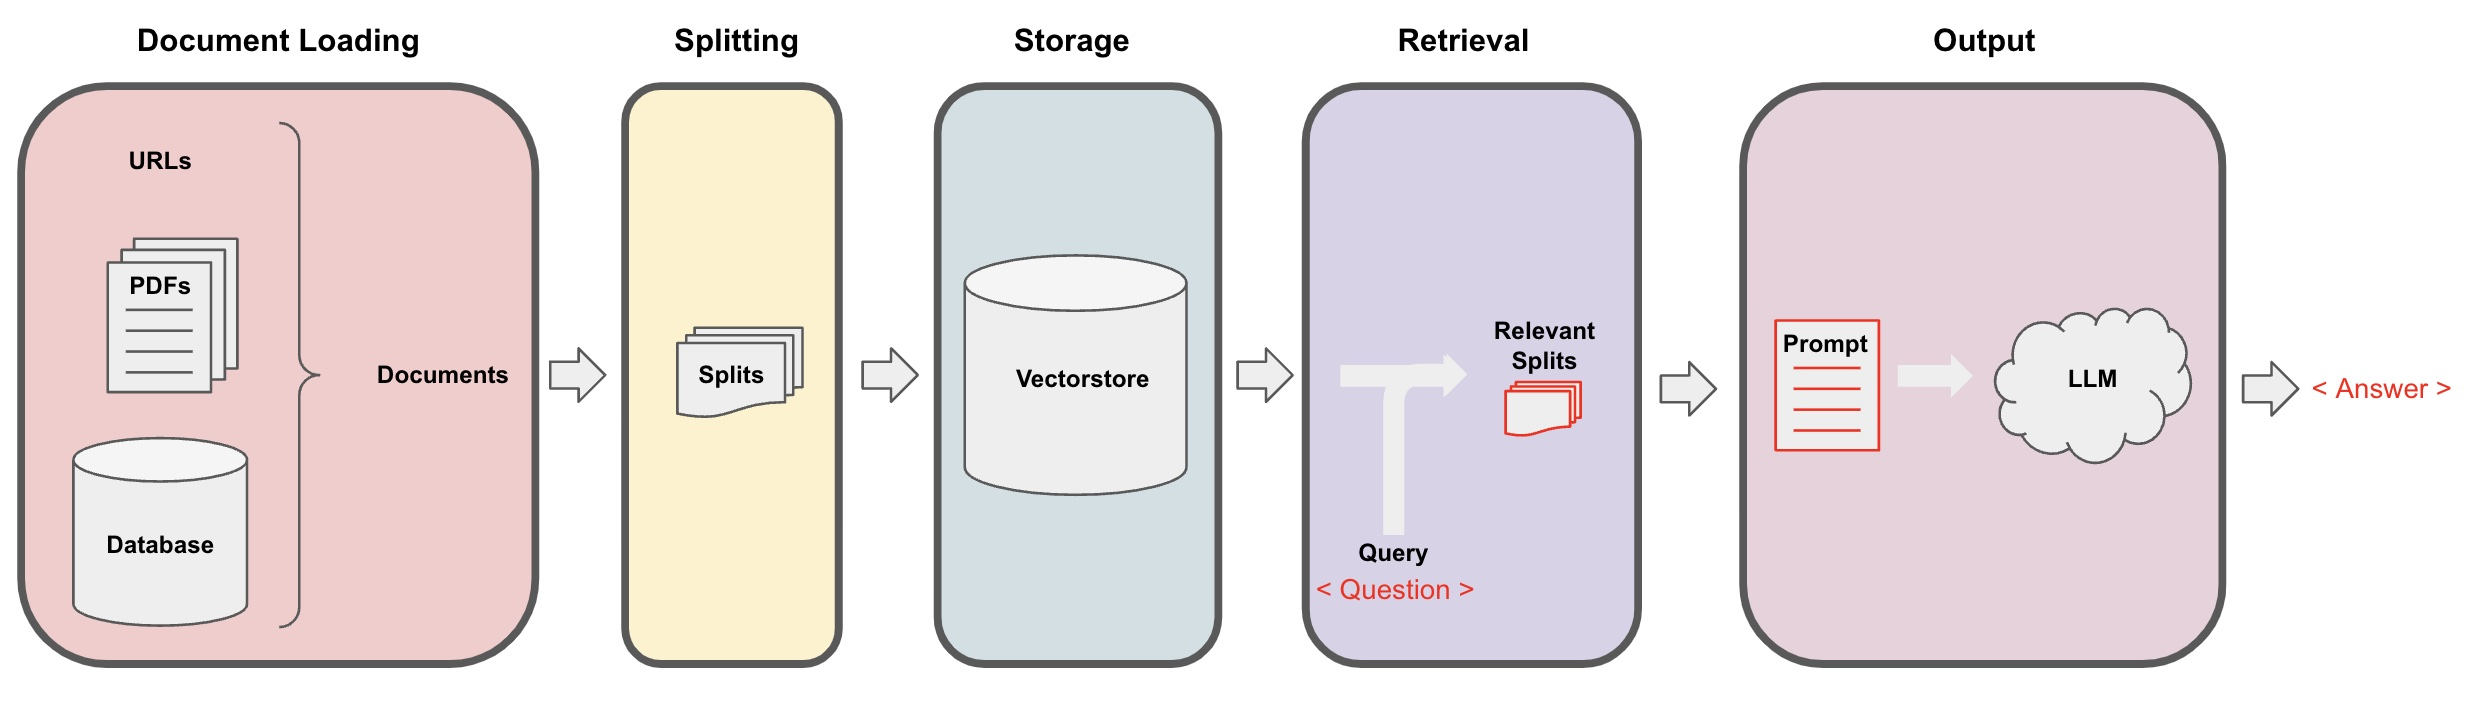
### 摄入 Ingestion
为了使用语言模型与数据进行交互，您首先需要将其转换为适合的格式。这种格式可以是索引（ Index ）。通过将数据放入索引中，可以使后续的步骤更容易与之交互。

有几种类型的索引，但最常见的是向量存储（ Vectorstore ）。将文档摄入到向量存储中可以按照以下步骤完成：

1. 加载文档（使用文档加载器）
2. 分割文档（使用文本分割器）
3. 为文档创建嵌入（使用文本嵌入模型）
4. 将文档和嵌入存储到向量存储中
### 生成 Generation
现在我们有了一个索引，如何使用它进行生成呢？可以将此过程分为以下步骤：

1. 接收用户提问
2. 在索引中查找与问题相关的文档
3. 使用问题和任何相关文档构建一个 PromptValue（使用 PromptTemplate ）
4. 将PromptValue传递给模型
5. 获取结果并返回给用户。

LangChain为RAG应用程序提供了所有的从简单到复杂的构建模块。下面这个案例中，将基于Langchain架构逐步实现上述两个步骤，构建简单的推免知识问答系统。

## 初始环境配置

In [6]:
# !conda create -n baoyan python=3.10
# !conda activate baoyan
# !pip install langchain
# !pip install unstructured
# !pip install markdown
# !pip install modelscope
# !pip install qianfan
# !pip install gradio
# !pip install chromadb
# !pip install openai
# !pip install streamlit
# !pip install gradio

   ---------------------------------------- 0.0/295.1 kB ? eta -:--:--
   ----- ---------------------------------- 41.0/295.1 kB 1.9 MB/s eta 0:00:01
   --------------- ------------------------ 112.6/295.1 kB 1.3 MB/s eta 0:00:01
   -------------------------- ------------- 194.6/295.1 kB 1.5 MB/s eta 0:00:01
   ------------------------------------- -- 276.5/295.1 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 295.1/295.1 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/329.2 kB ? eta -:--:--
   ------------- -------------------------- 112.6/329.2 kB 3.3 MB/s eta 0:00:01
   ------------------------ --------------- 204.8/329.2 kB 2.5 MB/s eta 0:00:01
   ------------------------------------- -- 307.2/329.2 kB 2.7 MB/s eta 0:00:01
   ---------------------------------------- 329.2/329.2 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/240.7 kB ? eta -:--:--
   -------------------- ------------------- 122.9/240.7 kB 3.6 MB/s 

## 摄入 Ingestion

### Step1：Document Loading：Markdown

基于Langchain，从/data目录下读取“推免问答贴”数据。

In [1]:
# 数据存放在/data目录下
import os
import glob
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import TextLoader
# 设定文件夹路径
folder = './data'
# 利用os和glob获取文件夹内所有 .md 文件
loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader)
docs = loader.load()
md_files = glob.glob(os.path.join(folder, '*.md'))
# 创建空的data列表来存储所有文件的内容
data = []
for md_file in md_files:
    print(md_file)
    loader = UnstructuredMarkdownLoader(md_file)
    file_data = loader.load()
    data+=file_data
docs,data,len(data)

./data\1.md
./data\2.md
./data\3.md
./data\4.md


([Document(page_content="### 个人背景\n\n- 西北电专AI\n- 推免去向：上海交通大学计算机系直博\n- 【不用开盒我，没必要/doge，认识的都认识。写这一篇是因为整理材料发现了夏令营用到的一些物料，包括套磁信模板，个人简历制作，英语面试问题】\n\n### 0. 保研黑话\n\n- rk: rank,般指自己的加权或绩点排名\n- title: 学校的牌子，如清北、华五、985、211、双非、四非、中九、末九等。\n  - 双非：指的非92，但是是双一流。\n  - 四非：在双非基础上还不是双一流\n- 强com/弱com：即committee，表示学院的话语权\n  - 弱com表示学院话语权弱，导师话语权强，导师可以捞你入营\n  - 强com表示学院话语权强，导师话语权弱，导师不太能决定入营or录取\n  - 强弱com是相对的，你强它就弱，你弱它就强\n- bar: 门槛\n  - 指的是入营所需要的门槛\n  - 一般学院会以title和rk来区分\n  - 当前两者不占优势的时候，ACM牌子和论文就是一个区分点\n- wl: waiting list，候补名单。\n- oq: over qualified，指学生报名比自身本科院校或者能力水平低很多的院校。\n- 928/929：\n  - 保研系统开放当天(特别地，2023年是929)\n  - 每个人只能填写最多三个志愿，相互独立\n  - 先接受复试，再接受拟录取。\n  - 但需要在指定时间内接受，否则offer直接作废\n- 常见的专业代码：0839 (网安) 、0812 (计算机科学与技术) 、0835 (软件工程)、0854(电子信息专硕、不细分方向为085400、细分方向为计算机085404、软工085405等)\n\n### 1. 套磁信模板\n\n尊敬的xxx老师/教授，\n\n您好！见字如面。\n\n我是XXX大学XXX专业的XXX级本科生XXX，很抱歉占用老师您宝贵的时间。我目前正在准备保研申请，在我深入了解贵校及您的研究方向后，我对贵校的学术氛围和老师您的科研实力深感钦佩，因此我想咨询老师明年是否还有研究生/博士生/实习生名额，我非常希望能参与到老师的科研任务当中，希望在老师的指导下参与到高质量、高水平的科研工作中去。\n\n在本科期间，我专

### Step2：Document Splitting

将文档进行切片

In [2]:
from langchain.text_splitter import MarkdownHeaderTextSplitter
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on,strip_headers=False)
md_header_splits=[]
for doc in docs:
    md_header_splits += markdown_splitter.split_text(doc.page_content)
md_header_splits[20]

Document(page_content='### 个人背景  \n- 本科院校：西北某中上211，人工智能学院图灵人工智能科学实验班  \n排名：**3/35**（前五、六学期，8.57%），2/37（综合排名，5.4%）  \n英语：CET-4 563，CET-6 559  \n竞赛：数模美赛Finalist(2023)，数模国赛省一，数竞非数学类省一等没啥用的竞赛  \n科研：夏令营报名时只有自己做的多模态小项目(如下)和一个省级大创（AI交叉，比较水），2023.06-2023.08在上海交大GAIR实验室实习，期间参与2个NLP领域研究，论文2篇在投(非主要作者)。  \n- **最终去向**：浙江大学计算机学院直博  \n- | 学校-学院-类型                   | 入营情况 | 原因                                                         | offer情况    |\n| -------------------------------- | -------- | ------------------------------------------------------------ | ------------ |\n| 复旦大学-类脑-直博               | 未入营   | 211rk3不好进，bar高                                          | /            |\n| 中山大学-cs-学硕                 | 未入营   | 好家伙当头一棒                                               | /            |\n| 同济大学-智能科学与技术-学硕     | 未入营   | 好家伙你也一棒                                               | /            |\n| 上海科技大学-信息学院-学硕       | 入营     | 未参营，由于自认为最终不会去                                 | /            |\n| 上海交通大学-电院

In [5]:
# Char-level splits
from langchain.text_splitter import RecursiveCharacterTextSplitter
chunk_size = 500
chunk_overlap = 50
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
# Split
splits = text_splitter.split_documents(md_header_splits)
splits
# Split within each header group
all_splits=[]
all_metadatas=[]  
for split in splits:
    all_splits.append(split.page_content)
    all_metadatas.append(split.metadata)
len(all_metadatas),len(all_splits),all_metadatas[5],all_splits[5]

(75,
 75,
 {'Header 3': '2. 个人简历模板'},
 '### 2. 个人简历模板  \n个人简历的制作主要推荐以下几种  \n1. 超级简历制作\n2. LaTex/Typst制作\n3. Word/PPT制作  \n在制作个人简历时，应该突出（加粗）自己的强项，弱化（或者不谈）自己的弱的项。在介绍自己的比赛/论文时，应该突出自己的贡献和效果的提升，加强数字的概念。')

### Step3：vectorstores_and_embeddings

从[百度千帆云平台](https://console.bce.baidu.com/qianfan/ais/console/applicationConsole/application)获取Embedding模型的API，调用Embedding模型将文本转化为数值向量，并存储在chroma向量数据库中

In [6]:
# Embedding模型API调用与测试
from langchain_community.embeddings import QianfanEmbeddingsEndpoint

# os.environ["QIANFAN_AK"] = "your_ak"
# os.environ["QIANFAN_SK"] = "your_sk"
# 从千帆云平台获取Emb模型API

embed = QianfanEmbeddingsEndpoint(
    qianfan_ak='QIANFAN_AK',
    qianfan_sk='QIANFAN_SK',
    model="bge_large_zh", endpoint="bge_large_zh"
)
res = embed.embed_documents(["hi", "world"])

for r in res:
    print(r[:8])

[INFO] [03-23 14:13:39] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh
[INFO] [03-23 14:13:39] oauth.py:207 [t:21952]: trying to refresh access_token for ak `QkbdYd***`
[INFO] [03-23 14:13:39] oauth.py:220 [t:21952]: sucessfully refresh access_token


[-0.0001582596160005778, -0.025089964270591736, -0.03997539356350899, 0.013156415894627571, 0.000135212714667432, 0.012428865768015385, 0.016216561198234558, -0.04126659780740738]
[0.0019113451708108187, -0.008625439368188381, -0.0531032420694828, -0.0018436014652252197, -0.01818147301673889, 0.010310115292668343, -0.008867680095136166, -0.021067561581730843]


In [7]:
# Embedding
from langchain_community.embeddings import ModelScopeEmbeddings
from langchain_community.vectorstores import Chroma

persist_directory = 'docs/chroma/'# persist_directory为chroma向量数据库存放路径
db = Chroma.from_documents(
    documents=splits, 
    embedding=embed, 
    persist_directory=persist_directory
    )
print(db._collection.count())

[INFO] [03-23 14:18:00] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh
[INFO] [03-23 14:18:02] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh
[INFO] [03-23 14:18:04] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh
[INFO] [03-23 14:18:05] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh
[INFO] [03-23 14:18:07] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh


75


In [9]:
# 相似度检索测试
query="华东师范大学计算机学院怎么考核的？"
Search_docx = db.similarity_search(query,k=3)
for i in Search_docx:
    print(i.page_content)

[INFO] [03-23 14:18:41] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh


### 2. 面试经历
### 2. 面试经历
- 先接受复试，再接受拟录取。
- 但需要在指定时间内接受，否则offer直接作废
- 常见的专业代码：0839 (网安) 、0812 (计算机科学与技术) 、0835 (软件工程)、0854(电子信息专硕、不细分方向为085400、细分方向为计算机085404、软工085405等)


In [10]:
db.persist() 

## 生成 Generation
### Step4：Retrieval

In [15]:
# 可以通过下述代码直接调用向量数据库中的内容
# from langchain_community.embeddings import QianfanEmbeddingsEndpoint
# from langchain.vectorstores import Chroma
# from langchain.embeddings.openai import OpenAIEmbeddings
# persist_directory = 'docs/chroma/'
# embedding = QianfanEmbeddingsEndpoint(
#     qianfan_ak='QIANFAN_AK',
#     qianfan_sk='QIANFAN_SK',
#     model="bge_large_zh", endpoint="bge_large_zh"
# )
# vectordb = Chroma(
#     persist_directory=persist_directory,
#     embedding_function=embedding
# )

In [12]:
# todo:参考https://learn.deeplearning.ai/courses/langchain-chat-with-your-data/lesson/5/retrieval，https://js.langchain.com.cn/docs/modules/indexes/retrievers/，找到一种效果比较好的Retriever，暂时使用similarity_search
retriever = db.as_retriever(search_kwargs={"k": 5},search_type="mmr")
docs11 = retriever.get_relevant_documents("强com弱com")
docs11

[INFO] [03-23 14:22:06] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh


[Document(page_content='### 2. 面试经历', metadata={'Header 3': '2. 面试经历'}),
 Document(page_content='### 1. 保研黑话  \nnlp: 自然语言处理  \npku：北京大学  \nthu：清华大学  \nzju: 浙江大学  \nustc: 中国科学技术大学  \nsjtu: 上海交通大学  \nxjtu: 西安交通大学  \nfdu: 复旦大学  \nn多：特别多，非常多  \n强com/弱com：即committee，表示学院的话语权  \n- 弱com表示学院话语权弱，导师话语权强，导师可以捞你入营\n- 强com表示学院话语权强，导师话语权弱，导师不太能决定入营or录取\n- 强弱com是相对的，你强它就弱，你弱它就强  \nGNN：图神经网络  \nap: 助理教授  \ncs：计算机科学学院/计算机科学与技术专业  \n555：“呜呜呜呜”,表示伤心  \n233：表示语气增强  \nqwq:  类似颜文字，表示伤心，惋惜  \nlambda课题组：南京大学周志华团队  \nDM：Data Mining（数据挖掘）  \nRL：Reinforce Learning （强化学习）  \nbar: 门槛  \n- 指的是入营所需要的门槛\n- 一般学院会以title和rank来区分', metadata={'Header 3': '1. 保研黑话'}),
 Document(page_content='### 2. 个人简历模板  \n个人简历的制作主要推荐以下几种  \n1. 超级简历制作\n2. LaTex/Typst制作\n3. Word/PPT制作  \n在制作个人简历时，应该突出（加粗）自己的强项，弱化（或者不谈）自己的弱的项。在介绍自己的比赛/论文时，应该突出自己的贡献和效果的提升，加强数字的概念。', metadata={'Header 3': '2. 个人简历模板'}),
 Document(page_content="Xi'an is renowned for its historical significance as it served as the capital of multiple ancient dynasties in Chin

### Step5：PromptTemplate


In [13]:
from langchain.prompts import PromptTemplate

# Build prompt
template = (
        "你是一名计算机推免领域的专家，你的任务是基于下面的上下文、为用户所提出的问题，生成一个适合的答案。\n\n"
        "上下文：{context}\n\n"
        "问题为: {question}\n\n"
        "请基于上述所有信息，将你的专业知识和判断结合起来，生成一个最满足问题的答案。\n"
        )
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)
QA_CHAIN_PROMPT

PromptTemplate(input_variables=['context', 'question'], template='你是一名计算机推免领域的专家，你的任务是基于下面的上下文、为用户所提出的问题，生成一个适合的答案。\n\n上下文：{context}\n\n问题为: {question}\n\n请基于上述所有信息，将你的专业知识和判断结合起来，生成一个最满足问题的答案。\n')

### Step6：Question Answering

In [21]:
# 测试使用的OpenAI
from langchain_openai import OpenAI

llm = OpenAI(openai_api_key="openai-api-key")

In [22]:
from langchain.chains import LLMChain
prompt = PromptTemplate.from_template(template)
llm_chain = LLMChain(prompt=prompt, llm=llm)

In [23]:
llm_chain.run("什么是自由")

'\n自由是指个人或集体能够自主选择、决定和行使自己的行动和权利的状态。它包括政治上的自由、经济上的自由、社会上的自由和精神上的自由。政治上的自由是指个人和群体有权利参与政治决策，表达自己的意见和观点，选择自己的领导人和政府。经济上的自由是指个人有权利拥有和支配自己的财产，自主决定自己的经济活动。社会上的自由是指个人有权利选择自己的生活方式和社交圈子，不受限制。精神上的自由是指个人有权利思考、信仰和表达自己的想法和信仰，不受强制和压迫。总的来说，自由'

In [24]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=db.as_retriever()
)
# 
template = """{question}"""
def QA(question):
    retrieval_data = retriever.get_relevant_documents(question)
    basic_result = llm_chain.run(question)
    result = qa_chain({"query": question})
    return {
        "无知识库生成结果":basic_result,
        "检索结果":retrieval_data,
        "RAG增强生成结果":result["result"]
    }

In [25]:
retrieval_data = retriever.get_relevant_documents("强com和弱com是什么意思？")
strings=""
for i in retrieval_data:
    strings+=i.page_content
    strings+="\n\n"
print(strings)

[INFO] [03-23 14:28:09] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh


### 2. 面试经历

### 1. 保研黑话  
nlp: 自然语言处理  
pku：北京大学  
thu：清华大学  
zju: 浙江大学  
ustc: 中国科学技术大学  
sjtu: 上海交通大学  
xjtu: 西安交通大学  
fdu: 复旦大学  
n多：特别多，非常多  
强com/弱com：即committee，表示学院的话语权  
- 弱com表示学院话语权弱，导师话语权强，导师可以捞你入营
- 强com表示学院话语权强，导师话语权弱，导师不太能决定入营or录取
- 强弱com是相对的，你强它就弱，你弱它就强  
GNN：图神经网络  
ap: 助理教授  
cs：计算机科学学院/计算机科学与技术专业  
555：“呜呜呜呜”,表示伤心  
233：表示语气增强  
qwq:  类似颜文字，表示伤心，惋惜  
lambda课题组：南京大学周志华团队  
DM：Data Mining（数据挖掘）  
RL：Reinforce Learning （强化学习）  
bar: 门槛  
- 指的是入营所需要的门槛
- 一般学院会以title和rank来区分

### 2. 个人简历模板  
个人简历的制作主要推荐以下几种  
1. 超级简历制作
2. LaTex/Typst制作
3. Word/PPT制作  
在制作个人简历时，应该突出（加粗）自己的强项，弱化（或者不谈）自己的弱的项。在介绍自己的比赛/论文时，应该突出自己的贡献和效果的提升，加强数字的概念。

Xi'an is renowned for its historical significance as it served as the capital of multiple ancient dynasties in China, including the Qin, Han, and Tang dynasties. One of the city's most famous attractions is the Terracotta Army, an incredible archaeological discovery consisting of thousands of life-sized clay soldiers and horses. It is truly a remark

## 三个测试案例

In [26]:
question1 = "强com和弱com是什么意思？"
answer1 = QA(question1)
answer1

[INFO] [03-23 14:28:32] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh
c:\Users\34588\.conda\envs\baoyan\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
[INFO] [03-23 14:28:38] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh


{'无知识库生成结果': '\n强com和弱com是指公司在市场竞争中的竞争实力和地位。\n\n强com一般指具有强大的资金实力、雄厚的品牌影响力、领先的技术和先进的管理模式的公司。这些公司通常在市场上具有较大的市场份额和较高的盈利能力，能够抵御市场风险和竞争压力。\n\n相反，弱com指的是资金实力、品牌影响力、技术实力和管理模式等方面相对较弱的公司。这些公司通常在市场上处于较低的地位，面临较大的市场风险和竞争压力，盈利能力较弱。\n\n在市场经济中，强com和弱com的存在是正常的现象，它们相互竞',
 '检索结果': [Document(page_content='### 2. 面试经历', metadata={'Header 3': '2. 面试经历'}),
  Document(page_content='### 1. 保研黑话  \nnlp: 自然语言处理  \npku：北京大学  \nthu：清华大学  \nzju: 浙江大学  \nustc: 中国科学技术大学  \nsjtu: 上海交通大学  \nxjtu: 西安交通大学  \nfdu: 复旦大学  \nn多：特别多，非常多  \n强com/弱com：即committee，表示学院的话语权  \n- 弱com表示学院话语权弱，导师话语权强，导师可以捞你入营\n- 强com表示学院话语权强，导师话语权弱，导师不太能决定入营or录取\n- 强弱com是相对的，你强它就弱，你弱它就强  \nGNN：图神经网络  \nap: 助理教授  \ncs：计算机科学学院/计算机科学与技术专业  \n555：“呜呜呜呜”,表示伤心  \n233：表示语气增强  \nqwq:  类似颜文字，表示伤心，惋惜  \nlambda课题组：南京大学周志华团队  \nDM：Data Mining（数据挖掘）  \nRL：Reinforce Learning （强化学习）  \nbar: 门槛  \n- 指的是入营所需要的门槛\n- 一般学院会以title和rank来区分', metadata={'Header 3': '1. 保研黑话'}),
  Document(page_content='### 2. 个人简历模板  \n个人简历的制作主要推荐以下几种  \n1. 超级简历制作\n2. LaTex/Typst制作\n3. W

In [27]:
question2 = "怎么制作个人简历？"
answer2 = QA(question2)
answer2

[INFO] [03-23 14:28:46] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh
[INFO] [03-23 14:28:51] openapi_requestor.py:316 [t:21952]: requesting llm api endpoint: /embeddings/bge_large_zh


{'无知识库生成结果': '制作个人简历是向雇主展示自己能力和经历的重要工具，它能帮助你获得面试机会。下面是制作个人简历的步骤：\n\n1. 选择合适的格式：个人简历有三种常见格式，包括传统的倒叙式简历、功能式简历和组合式简历。选择最适合你的格式能够更好地突出你的优势和经历。\n\n2. 添加个人信息：在简历的开头，包括你的全名、联系方式、地址和电子邮件地址。确保这些信息准确无误。\n\n3. 概述你的目标：在简历的开头，写一段简短的自我介绍，概括你的个人特质和目标。这可以让雇主更容易地了解你的能力和职业目标。\n\n4. 强调你的工作经历：',
 '检索结果': [Document(page_content='### 2. 个人简历模板  \n个人简历的制作主要推荐以下几种  \n1. 超级简历制作\n2. LaTex/Typst制作\n3. Word/PPT制作  \n在制作个人简历时，应该突出（加粗）自己的强项，弱化（或者不谈）自己的弱的项。在介绍自己的比赛/论文时，应该突出自己的贡献和效果的提升，加强数字的概念。', metadata={'Header 3': '2. 个人简历模板'}),
  Document(page_content='### 2. 面试经历', metadata={'Header 3': '2. 面试经历'}),
  Document(page_content='- 先接受复试，再接受拟录取。\n- 但需要在指定时间内接受，否则offer直接作废\n- 常见的专业代码：0839 (网安) 、0812 (计算机科学与技术) 、0835 (软件工程)、0854(电子信息专硕、不细分方向为085400、细分方向为计算机085404、软工085405等)', metadata={'Header 3': '0. 保研黑话'}),
  Document(page_content="**3.5 介绍你的家乡** Can you tell me a little bit about your hometown?  \n[我觉得chatGPT写的比我好] Certainly! I come from Xi'an, a city with a rich history and cultural heritage in China. Xi'an is loc

In [40]:
question3 = "有关于人大高瓴的入营经验分享吗？"
answer3 = QA(question3)
answer3

[INFO] [03-04 18:38:05] openapi_requestor.py:316 [t:24320]: requesting llm api endpoint: /embeddings/bge_large_zh
[INFO] [03-04 18:38:09] openapi_requestor.py:316 [t:24320]: requesting llm api endpoint: /embeddings/bge_large_zh


{'无知识库生成结果': '\n人大高瓴是由中国人民大学和高瓴资本共同合作创办的高端商业领袖培训营。它旨在为高校学生和创业者提供专业的商业知识和实践经验，帮助他们成为未来的商业领袖。\n\n入营经验：\n\n1. 提前了解营员要求和课程设置：在申请入营之前，可以提前了解营员要求和课程设置，以便更好地准备入营所需的材料和知识。\n\n2. 注重个人素质和能力：人大高瓴是一个高端商业领袖培训营，因此营员的个人素质和能力也是入营的重要因素。在申请过程中，要充分展现自己的领导能力、团队',
 '检索结果': [Document(page_content='## 2 夏令营  \n未入营：人大高瓴', metadata={'Header 2': '2 夏令营'}),
  Document(page_content='### 2.4 人大高瓴  \nbar真的很高！而且是强com！强强强com！我当时找了两个老师给我写推荐信，一个是本科科研导师，这位导师和高瓴的zx老师很熟，另外一个是原来在人大教过书的老师。所以我以为能混个脸熟帮我捞入营，但事实证明也只能是给老师留个印象加个vx这样子，入营老师帮不了一点。最后没入营呜呜呜', metadata={'Header 3': '2.4 人大高瓴'}),
  Document(page_content='总之，高瓴在立德楼，真的很新很炫酷！东门毗邻“人民大学”地铁站，非常不错！  \n最后我拿到了优营，也算是给我夏令营放弃了很多参营机会兜了底，感谢高瓴！', metadata={'Header 3': '2.1 人大高瓴'}),
  Document(page_content='| 北航 | 计算机     | 直博 | 入营，未参加   |\n| 中山 | 计算机     | 学硕 | 入营，未参加   |\n| 人大 | 高瓴       | 学硕 | 未入营         |', metadata={'Header 3': '个人背景'}),
  Document(page_content='高瓴报道后有时间就参观了一下教学楼，他们的立德（也就是高瓴的楼）楼也太特么高级了吧！！！！！！  \n![img](https://picx.zhimg.com/80/v2-2379935676f1258c58f7a1b4b61db153

## 可视化

gradio是一个可视化框架，通过简单的几行代码即可构建一个可视化小程序

In [ ]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")
demo.launch(share=True)   

In [66]:
from gradio import Interface
from langchain_community.embeddings import QianfanEmbeddingsEndpoint
from langchain.vectorstores import Chroma
from langchain_openai import OpenAI
from langchain.chains import LLMChain
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import gradio as gr

persist_directory = 'docs/chroma/'

embedding = QianfanEmbeddingsEndpoint(
    qianfan_ak='QIANFAN_AK',
    qianfan_sk='QIANFAN_SK',
    model="bge_large_zh", endpoint="bge_large_zh"
)

vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)


llm = OpenAI(openai_api_key="openai-api-key")

template = """{question}"""
prompt = PromptTemplate.from_template(template)
llm_chain = LLMChain(prompt=prompt, llm=llm)

def QA(question, top_k, mode):
    if mode == "基于检索":
        retrievers = vectordb.as_retriever(search_kwargs={"k": top_k})
        qa_chain = RetrievalQA.from_chain_type(llm, retriever=retrievers)
        retrieval_data = retrievers.get_relevant_documents(question)
        strings=""
        for i in retrieval_data:
            strings+=i.page_content
            strings+="\n\n"
        result = qa_chain({"query": question})
        return str(retrieval_data), str(result["result"])," "
    else:  
        basic_result = llm_chain.run(question)
        return " ",  " ",basic_result
    

demo = Interface(
    QA,
    [
        gr.Textbox("什么是强com？", placeholder="请输入你的问题..."),
        gr.Slider("top_k值", minimum=3, maximum=10, value=5, step=1),
        gr.Radio(["基于检索", "不基于检索"], label="问答模式",value="不基于检索"),
    ],
    [
        gr.Textbox(label="检索结果", type="text"),
        gr.Textbox(label="增强生成结果", type="text"),
        gr.Textbox(label="无知识库生成结果", type="text"),
    ],
    title="推免问答助手",
    description="请向模型提出你的问题。"
)

if __name__ == "__main__":
    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7876
Running on public URL: https://8ff68dfbb614cc7baf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


[INFO] [03-04 22:20:29] openapi_requestor.py:316 [t:6052]: requesting llm api endpoint: /embeddings/bge_large_zh
[INFO] [03-04 22:20:30] openapi_requestor.py:316 [t:6052]: requesting llm api endpoint: /embeddings/bge_large_zh
